## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [ ]:
# Today's cameras all use lenses which make 2D image distort, so called camera calibration problem
# There are two common distortion:
# (1) Radial distortion, which makes stright lines appear curved, or objects appear more or less curved 
#     than the they actually are.
# (2) tangential distorion, which occurs 
#     because image taking lense is not aligned perfectly parrllel to the imaging plane.
#
# So this part is the practice to undistort the images effected by both radial and tangential distortion.

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt5

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
# use numpy mgrid function to generate the coordinates values for a given grid size.
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners in distorted calibration images.
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard's inner corners,
    # (x, y) should pass only points where two black and two white squares intersects.
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners to see what was detected.
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)
        

# cv2.destroyAllWindows()


import pickle

img = cv2.imread('../camera_cal/calibration1.jpg')

# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
#
# feed objpoints, imgpoints, and shape of the grayscale image into calibrateCamera function 
# to calculate the distortion cofficients (dist)
# and the camera matrix that we need to transform 3D object points to 2D image points
#
# mtx: Camera Matrix, which only depends on the camera only. so once calculated, it can be stored for future purposes.
# dist: Distortion coefficients, which depends on samples. so once calculated, it can be reused onto the same things 
#       as samples with different angles and orientation.
def store_dist_and_mtx(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    print("mtx: ", mtx)
    print("dist: ", dist)
    # we only calculate once and store it into pickle 
    # so that we could reuse mtx and dist on every chessboard images in camera_cal folder.
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump( dist_pickle, open('mtx_and_dist_pickle.p', 'wb'))

store_dist_and_mtx(img, objpoints, imgpoints)

## And so on and so forth...

In [ ]:
# Apply a distortion correction to raw images.
with open('mtx_and_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

%matplotlib inline

for img in images:
    index = img.rfind('/') + 1
    filename = img[index:]
    img = cv2.imread(img)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('../output_images/undistort_images/'+filename, undist_img)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=50)
# ax2.imshow(undistorted)
# ax2.set_title('Undistorted Image', fontsize=50)
# plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

In [64]:
from camera_calibrate import CameraCalibration
import glob
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
images = glob.glob('../camera_cal/calibration*.jpg')
cal = CameraCalibration(images)

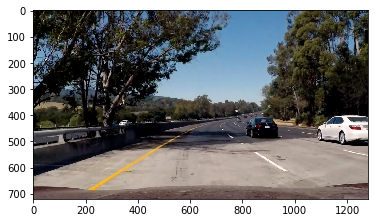

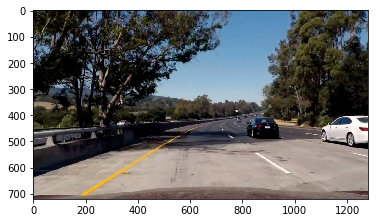

In [105]:
img = mpimg.imread('../test_images/test5.jpg')


plt.imshow(img)
plt.show()

img = cal(img)

plt.imshow(img)
plt.show()

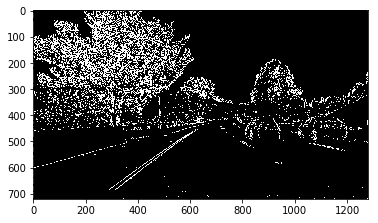

In [229]:
# Use color transforms, gradients, etc., to create a thresholded binary image.

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), debug=False):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return the result
    if debug == True:
        plt.imshow(binary_output, cmap='gray')
        plt.show()
    
    return binary_output

binary = abs_sobel_thresh(img, thresh=(20, 100), debug=True)

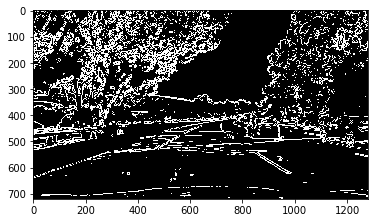

In [69]:
def magnitude_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gredient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    gradmag = (255*gradmag/np.max(gradmag)).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output

binary = magnitude_thresh(img, sobel_kernel=9, thresh=(30, 100))

plt.imshow(binary, cmap='gray')

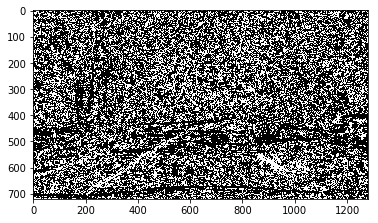

In [70]:
def direction_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

binary = direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(binary, cmap='gray')

In [29]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(40, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(40, 100))
mag_binary = magnitude_thresh(img, sobel_kernel=9, thresh=(30, 100))
dir_binary = direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

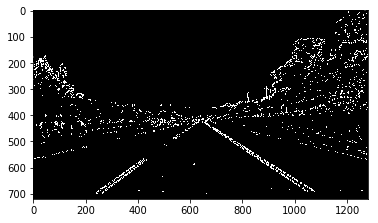

In [42]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) | (mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')

In [140]:
def hls_select(img, channel='S', thresh=(0, 255), debug=False):
    """
        Apply threshold on image with hls colorspace.
        
        Parameters
        ----------
        img          : RGB image.
        channel      : Select channel to apply threshold on. If channel is 'HLS' then don't apply threshold.
        thresh       : the range is only useful when channel is not 'HLS' or 'hls'.
        debug        : If debug equals True then display result. 
                       
        return
        ----------
        None          : if channel == 'HLS', 'hls'
        binary_output : binary image if channel == 'H', 'L', 'S', 'h', 'l', 's'
    """

    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = channel.upper()
    
    if channel == 'H':
        channel_img = hls[:, :, 0]
    elif channel == 'L':
        channel_img = hls[:, :, 1]
    elif channel == 'S':
        channel_img = hls[:, :, 2]
    elif channel == 'HLS' and debug == True:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]

        axes[0].set_title('H')
        axes[0].set_axis_off()
        axes[1].set_title('L')
        axes[1].set_axis_off()
        axes[2].set_title('S')
        axes[2].set_axis_off()
        axes[0].imshow(H, cmap='gray')
        axes[1].imshow(L, cmap='gray')
        axes[2].imshow(S, cmap='gray')
        return None
    else:
        return None
    
    binary_output = np.zeros_like(channel_img)
    binary_output[(channel_img > thresh[0]) & (channel_img <= thresh[1])] = 1
    
    if debug == True:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
        
        axes[0].set_title('original image')
        axes[0].set_axis_off()
        axes[0].imshow(img)        
        
        axes[1].set_title(channel + ' original')
        axes[1].set_axis_off()
        axes[1].imshow(channel_img, cmap='gray')

        axes[2].set_title(channel + ' with_range_select')
        axes[2].set_axis_off()
        axes[2].imshow(binary_output, cmap='gray')
        plt.show()
        
    return binary_output

In [153]:
def rgb_select(img, channel='R', thresh=(0, 255), debug=False):
    """
        Apply threshold on image with RGB colorspace.
        
        Parameters
        ----------
        img          : RGB image.
        channel      : Select channel to apply threshold on. If channel is 'RGB', then don't apply threshold.
        thresh       : the range is only useful when channel is not 'RGB' or 'RGB'.
        debug        : If debug equals True then display result and return None, 
                       
        return
        ----------
        None          : if channel == 'RGB', 'rgb'.
        binary_output : binary image if channel == 'R', 'G', 'B', 'r', 'g', 'b'
    """

    rgb = img.copy()
    channel = channel.upper()
    
    if channel == 'R':
        channel_img = rgb[:, :, 0]
    elif channel == 'G':
        channel_img = rgb[:, :, 1]
    elif channel == 'B':
        channel_img = rgb[:, :, 2]
    elif channel == 'RGB' and debug == True:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
        R = rgb[:,:,0]
        G = rgb[:,:,1]
        B = rgb[:,:,2]

        axes[0].set_title('R')
        axes[0].set_axis_off()
        axes[1].set_title('B')
        axes[1].set_axis_off()
        axes[2].set_title('G')
        axes[2].set_axis_off()
        axes[0].imshow(R, cmap='gray')
        axes[1].imshow(G, cmap='gray')
        axes[2].imshow(B, cmap='gray')
        plt.show()
        return None
    else:
        return None
    
    binary_output = np.zeros_like(channel_img)
    binary_output[(channel_img > thresh[0]) & (channel_img <= thresh[1])] = 1
    
    if debug == True:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
        
        axes[0].set_title('original image')
        axes[0].set_axis_off()
        axes[0].imshow(img)        
        
        axes[1].set_title(channel + ' original')
        axes[1].set_axis_off()
        axes[1].imshow(channel_img, cmap='gray')

        axes[2].set_title(channel + ' with_range_select')
        axes[2].set_axis_off()
        axes[2].imshow(binary_output, cmap='gray')
        plt.show()
        
    return binary_output

In [683]:
# img = mpimg.imread('../test_images/straight_lines2.jpg')
img = mpimg.imread('../test_images/test2.jpg')

r_binary = rgb_select(img, channel='R', thresh=(215, 255), debug=False)
# r_binary = rgb_select(img, channel='R', thresh=(215, 255), debug=True)
s_binary = hls_select(img, thresh=(70, 235), debug=False)
# s_binary = hls_select(img, thresh=(70, 235), debug=True)
gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 150), debug=False)
# gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 150), debug=True)
h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=False)
# h_binary = hls_select(img, channel='h', thresh=(17, 70), debug=True)

combined_binary = np.zeros_like(gradx_binary)
combined_binary[(gradx_binary == 1) | (((h_binary == 1) & (s_binary == 1)) | (r_binary == 1))] = 1

# plt.imshow(combined_binary, cmap='gray')

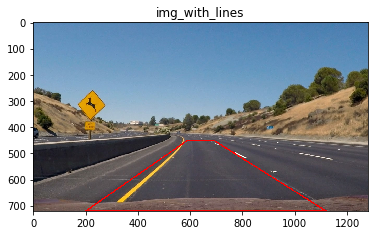

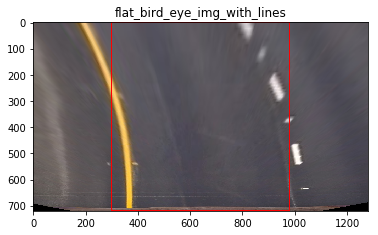

In [684]:
def perspective_transform(img, debug=False):
    # Get image dimensions
    
        
    (h, w) = (img.shape[0], img.shape[1])
    
    roi_y_top = h*0.625
    mid_x = w//2         # midden position of x coordinate in the given image
    offset = 50
    dst_w_offset = 300
    
    src_vertices = np.array([[mid_x + offset, roi_y_top], [w - 160, h], 
                             [200, h], [mid_x - offset, roi_y_top]], dtype=np.int32)
    dst_vertices = np.array([[w - dst_w_offset, 0], [w - dst_w_offset, h], 
                             [dst_w_offset, h]    , [dst_w_offset, 0]], dtype=np.int32)
        
    src = np.float32(src_vertices)
    dst = np.float32(dst_vertices)
    
    # perspective transform is a matrix that's returned by the function
    # getPerspectiveTranform
    M = cv2.getPerspectiveTransform(src, dst)
    
    img_size = (img.shape[1], img.shape[0])
    
    # Apply the transform M to the original image to get the wraped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if debug == True:
        # original img with line
        if img.ndim == 2:
            channel = np.uint8(255*img)
            img_with_lines = np.dstack((channel, channel, channel))
        else:
            img_with_lines = img.copy()
            
        pts = src_vertices.reshape((-1,1,2))
        lines = cv2.polylines(img_with_lines, [pts], True, (255,0,0), thickness=3)
        plt.title('img_with_lines')
        plt.imshow(img_with_lines)
        plt.show()
        
        # flat bird-eye img with line
        if img.ndim == 2:
            channel = np.uint8(255*warped)
            flat_bird_eye_img_with_lines = np.dstack((channel, channel, channel))
        else:
            flat_bird_eye_img_with_lines = warped.copy()
        pts = dst_vertices.reshape((-1,1,2))
        lines = cv2.polylines(flat_bird_eye_img_with_lines, [pts], True, (255,0,0), thickness=3)
        plt.title('flat_bird_eye_img_with_lines')
        plt.imshow(flat_bird_eye_img_with_lines)
        plt.show()

    return warped

perspective_transform(img, debug=True);
# perspective_transform(combined_binary, debug=True);